In [1]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)
    
net = torch.nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [2]:
X = torch.rand(size=(1,1,28,28), dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


数据集

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            print(y)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

training on cpu
tensor([7, 7, 8, 1, 4, 6, 1, 7, 5, 0, 5, 6, 1, 7, 6, 6, 4, 9, 2, 5, 2, 0, 5, 6,
        2, 6, 8, 9, 9, 7, 8, 6, 5, 2, 4, 1, 0, 4, 7, 1, 0, 3, 3, 2, 6, 4, 2, 3,
        2, 0, 4, 7, 6, 4, 1, 7, 4, 7, 8, 2, 4, 6, 2, 3, 2, 7, 8, 9, 0, 7, 7, 6,
        1, 0, 4, 0, 9, 8, 3, 3, 8, 1, 5, 8, 0, 9, 4, 3, 0, 5, 0, 2, 9, 3, 6, 8,
        8, 3, 1, 2, 9, 5, 8, 4, 6, 7, 4, 1, 2, 2, 7, 5, 8, 3, 8, 9, 7, 3, 9, 9,
        6, 4, 9, 2, 8, 2, 8, 0, 4, 4, 3, 9, 8, 0, 0, 5, 8, 6, 3, 4, 4, 4, 3, 5,
        4, 4, 3, 6, 9, 6, 2, 5, 5, 4, 9, 7, 9, 0, 8, 2, 7, 8, 2, 0, 3, 1, 8, 5,
        7, 5, 3, 2, 0, 7, 5, 8, 5, 4, 9, 9, 2, 9, 0, 7, 3, 9, 3, 3, 6, 2, 9, 2,
        3, 7, 7, 4, 4, 3, 5, 3, 1, 6, 4, 8, 7, 3, 4, 4, 8, 6, 3, 6, 3, 9, 3, 9,
        5, 3, 7, 9, 7, 5, 8, 4, 6, 0, 3, 0, 7, 8, 7, 7, 5, 3, 8, 8, 1, 9, 7, 4,
        0, 9, 7, 2, 5, 0, 3, 1, 7, 9, 3, 3, 9, 2, 7, 0])
tensor([2, 3, 7, 8, 4, 2, 1, 3, 2, 3, 1, 1, 0, 2, 2, 8, 3, 0, 4, 4, 4, 8, 2, 2,
        1, 0, 4, 4, 1, 6, 7, 2, 4, 3, 7, 1, 2, 

KeyboardInterrupt: 

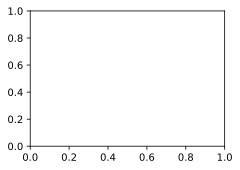

In [8]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())